In [21]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch import nn
import torch_geometric.nn as geom_nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import copy
import torch.nn.init as init

In [22]:
def particle_shift(particles,shift=10):

    ### Y shift ###
    y_pos = particles.copy()
    y_pos["y"] = particles["y"]+shift

    y_neg = particles.copy()
    y_neg["y"] = particles["y"]-shift

    ### Z shift ###
    z_pos = particles.copy()
    z_pos["z"] = particles["z"]+shift

    z_neg = particles.copy()
    z_neg["z"] = particles["z"]-shift

    ### Diagonal shifts ###
    ### y_pos_z_pos ###
    y_pos_z_pos = particles.copy()
    y_pos_z_pos["y"] = particles["y"]+shift
    y_pos_z_pos["z"] = particles["z"]+shift

    ### y_pos_z_neg ###
    y_pos_z_neg = particles.copy()
    y_pos_z_neg["y"] = particles["y"]+shift
    y_pos_z_neg["z"] = particles["z"]-shift

    ### y_neg_z_pos ###
    y_neg_z_pos = particles.copy()
    y_neg_z_pos["y"] = particles["y"]-shift
    y_neg_z_pos["z"] = particles["z"]+shift

    ### y_neg_z_neg ###
    y_neg_z_neg = particles.copy()
    y_neg_z_neg["y"] = particles["y"]-shift
    y_neg_z_neg["z"] = particles["z"]-shift

    return pd.concat([particles,y_pos,y_neg,z_pos,z_neg,y_pos_z_pos,y_pos_z_neg,y_neg_z_pos,y_neg_z_neg])

### array Differences function ###

def array_difference(array1,array2):
    ### First one must be the bigger array ###
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))
    
    # Find the set difference
    set_difference = set1 - set2

    # Convert the set difference back to a NumPy array
    return np.array(list(set_difference))

def add_const_parameter(data,const_param):

    ### Given a numpy array of size m*n , it will return a numpy array of size m*(n+1), where
    ### the last column has all elements as const_param ###

    add_column = np.ones(len(data))*const_param
    
    return np.hstack((data, add_column[:,None]))


def mirror_edge_index(edge_index):

    first_row = edge_index[0:1, :]
    second_row = edge_index[1:, :]
    output_tensor = np.concatenate((second_row, first_row), axis=0)
    
    return np.concatenate((edge_index,output_tensor),axis=1)


def weighted_averaging(data):
    
    idx = np.where(data[0][:,4]==0)[0]
    deg_1 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==1)[0]
    deg_2 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==2)[0]
    deg_3 = data[0][idx,1:4].sum()

    return deg_1 + 0.5*deg_2 + 0.25*deg_3 


def merge_columns_to_pandas_list(pandas_list,variable_list,master_dataframe):

    """ given a list of pandas dataframe with the x,y,z locations and re and phi ,this function will
        merge each pandas dataframe from the list with the master dataframe with all the columns  
    """

    joined = copy.deepcopy(pandas_list)

    for i in range(len(joined)):
        print("Particle number : ",str(i+1))
        
        temp = copy.deepcopy(joined[i])
        # print("Unjoined" , temp)
        add = pd.merge(temp,master_dataframe,how="inner",on=['Center_x','Re'],sort=False)[variable_list]
        joined[i] = pd.concat([temp,add], axis=1)
        # print("Joined" , joined[i])
        clear_output(wait=True)
        
    return joined
    
### Validation ###
# print(all_dat[0].edge_index[:,0:5])
# test = mirror_edge_index(all_dat[0].edge_index[:,0:5].detach().cpu().numpy())
# print(test)

In [23]:
# ### Reading Raw Data ###
# all_data_2p5 = pd.read_csv('AR2p5_all_particle_drag.dat.csv', header=0)

# ### Read all center data ###
# center_10 = pd.DataFrame(np.loadtxt("center_phi_10.dat"))
# center_10 = center_10.rename(columns={ center_10.columns[3]: "x" , center_10.columns[4]: "y" , center_10.columns[5]: "z"  })
# center_10_dev = center_10[(center_10['x']>7.5) & (center_10['x']<17.5)]

# center_20 = pd.DataFrame(np.loadtxt("center_phi_20.dat"))
# center_20 = center_20.rename(columns={ center_20.columns[3]: "x" , center_20.columns[4]: "y" , center_20.columns[5]: "z"  })
# center_20_dev = center_20[(center_20['x']>7.5) & (center_20['x']<17.5)]

# center_30 = pd.DataFrame(np.loadtxt("center_phi_30.dat"))
# center_30 = center_30.rename(columns={ center_30.columns[3]: "x" , center_30.columns[4]: "y" , center_30.columns[5]: "z"  })
# center_30_dev = center_30[(center_30['x']>7.5) & (center_30['x']<17.5)]

# ### Defining all particles ###
# center_shifted_10 = particle_shift(center_10,shift=10)[['x','y','z']]
# center_shifted_20 = particle_shift(center_20,shift=10)[['x','y','z']]
# center_shifted_30 = particle_shift(center_30,shift=10)[['x','y','z']]

# all_particles = np.concatenate((center_shifted_10,center_shifted_20,center_shifted_30))

In [24]:
# ### Sf=0.1 ###
# ### Generating the n nearest neighbors ###
# all_particles = center_shifted_10.copy()
# dev_particles = center_10_dev.copy()

# tree = cKDTree(all_particles.values)
# idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
# input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

# ### Adding solid fraction column ###
# input_dat = [add_const_parameter(input_dat[i],0.1) for i in range(len(input_dat))]

# ### Adding 4 Reynolds numbers and combining the datasets ###
# input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
#                               np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
#                               np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
#                               np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
#                     ) )
# input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

# ### Joing with df array to get inclination and drag and other quantities if needed ###
# input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
# input_dat_sf10 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
#                                        ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

In [25]:
# ### Sf=0.2 ###
# ### Generating the n nearest neighbors ###
# all_particles = center_shifted_20.copy()
# dev_particles = center_20_dev.copy()

# tree = cKDTree(all_particles.values)
# idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
# input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

# ### Adding solid fraction column ###
# input_dat = [add_const_parameter(input_dat[i],0.2) for i in range(len(input_dat))]

# ### Adding 4 Reynolds numbers and combining the datasets ###
# input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
#                               np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
#                               np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
#                               np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
#                     ) )
# input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

# ### Joing with df array to get inclination and drag and other quantities if needed ###
# input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
# input_dat_sf20 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
#                                        ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

In [26]:
# ### Sf=0.3 ###
# ### Generating the n nearest neighbors ###
# all_particles = center_shifted_30.copy()
# dev_particles = center_30_dev.copy()

# tree = cKDTree(all_particles.values)
# idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
# input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

# ### Adding solid fraction column ###
# input_dat = [add_const_parameter(input_dat[i],0.3) for i in range(len(input_dat))]

# ### Adding 4 Reynolds numbers and combining the datasets ###
# input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
#                               np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
#                               np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
#                               np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
#                     ) )
# input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

# ### Joing with df array to get inclination and drag and other quantities if needed ###
# input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
# input_dat_sf30 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
#                                        ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

In [27]:
# all_data = input_dat_sf10 + input_dat_sf20 + input_dat_sf30

In [28]:
# ### Converting to DataFrame and renaming the columns ###
# all_data_pd = pd.DataFrame(all_data,columns=["POI_x_coord","POI_y_coord","POI_z_coord","inclination_poi",
#                                              "neigh_1_x","neigh_1_y","neigh_1_z","inclination_1",
#                                              "neigh_2_x","neigh_2_y","neigh_2_z","inclination_2",
#                                              "neigh_3_x","neigh_3_y","neigh_3_z","inclination_3",
#                                              "neigh_4_x","neigh_4_y","neigh_4_z","inclination_4",
#                                              "neigh_5_x","neigh_5_y","neigh_5_z","inclination_5",
#                                              "neigh_6_x","neigh_6_y","neigh_6_z","inclination_6",
#                                              "neigh_7_x","neigh_7_y","neigh_7_z","inclination_7",
#                                              "neigh_8_x","neigh_8_y","neigh_8_z","inclination_8",
#                                              "neigh_9_x","neigh_9_y","neigh_9_z","inclination_9",
#                                              "neigh_10_x","neigh_10_y","neigh_10_z","inclination_10",
#                                              "neigh_11_x","neigh_11_y","neigh_11_z","inclination_11",
#                                              "neigh_12_x","neigh_12_y","neigh_12_z","inclination_12",
#                                              "neigh_13_x","neigh_13_y","neigh_13_z","inclination_13",
#                                              "neigh_14_x","neigh_14_y","neigh_14_z","inclination_14",
#                                              "neigh_15_x","neigh_15_y","neigh_15_z","inclination_15",
#                                               "Phi","Re","Drag_local"])
# # all_data_pd

In [29]:
## Translating the POI to the origin (keeping the POI coord values global , but making all the neighbors relative to it)###

# ## x-axis ###
# all_data_pd.loc[:, all_data_pd.columns.str.endswith('_x')] -= all_data_pd["POI_x_coord"].values[:,None]
# ### y-axis ###
# all_data_pd.loc[:, all_data_pd.columns.str.endswith('_y')] -= all_data_pd["POI_y_coord"].values[:,None]
# ### z-axis ###
# all_data_pd.loc[:, all_data_pd.columns.str.endswith('_z')] -= all_data_pd["POI_z_coord"].values[:,None]

In [30]:
# ### Splitting data as train and test ###
# check_points = np.array([0,center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],
#           center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],
#          center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0]]).cumsum() 

# test_indices = np.stack([np.arange(40) + check_points[i] for i in range(len(check_points)-1)]).flatten()
# train_indices = np.setdiff1d( np.arange(len(all_data_pd)) , test_indices )

# train_data_pd = all_data_pd.iloc[train_indices]
# test_data_pd = all_data_pd.iloc[test_indices]

In [31]:
# ### Scaling the train and test dataset ###
# scaler = MinMaxScaler()
# scaler.fit(train_data_pd)
# train_data_pd_scaled = scaler.transform(train_data_pd)
# test_data_pd_scaled = scaler.transform(test_data_pd)

# ### splitting to input and outputs ##3
# train_inputs,train_outputs = train_data_pd_scaled[:,0:66],train_data_pd_scaled[:,66:]
# test_inputs,test_outputs = test_data_pd_scaled[:,0:66],test_data_pd_scaled[:,66:]

In [32]:
### Load Data ###

data_location = "quick_load/single_experiment_ar5_sf_20_case_1/"

### All data ###
all_data_pd_scaled = np.load(data_location+"all_data_gnn.npy")

### Train ###
train_inputs = np.load(data_location+"train_inputs_MLP.npy")
train_inputs_global = np.load(data_location+"train_inputs_global.npy")
train_outputs = np.load(data_location+"train_outputs_MLP.npy")

### Test ###
test_inputs = np.load(data_location+"test_inputs_MLP.npy")
test_inputs_global = np.load(data_location+"test_inputs_global.npy")
test_outputs = np.load(data_location+"test_outputs_MLP.npy")

### Dropping nearest neighbors ###
train_inputs = np.array(train_inputs[:,0:20])
test_inputs = np.array(test_inputs[:,0:20])

### Tags and train/test indices and min-max drags ###
all_tags = np.load("quick_load/all_tags.npy")
train_indices = np.load(data_location+"train_indices.npy")
test_indices = np.load(data_location+"test_indices.npy")
min_max_drags = np.load(data_location+"min_max_drags.npy")

### Getting unscaled drags ###
test_outputs_unscaled = np.array( test_outputs*(min_max_drags[1]-min_max_drags[0]) + min_max_drags[0])
train_outputs_unscaled = np.array( train_outputs*(min_max_drags[1]-min_max_drags[0]) + min_max_drags[0])

In [33]:
### Define MLP model ###
class MLP(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(20, 256),
            # nn.Dropout(0.05),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,128),
            nn.Dropout(0.05),
            nn.LeakyReLU(),
            nn.Linear(128,32),
            nn.LeakyReLU(),
            # nn.Linear(32,32),
            nn.Dropout(0.05),
            # nn.ReLU(),
            # nn.Linear(32, 32) 
        )

        self.final_linear_1 = nn.Linear(35, 16)
        self.act = nn.LeakyReLU()
        self.final_linear_2 = nn.Linear(16,1)

        ### Init weights ###
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                
        init.xavier_uniform_(self.final_linear_1.weight)
        init.xavier_uniform_(self.final_linear_2.weight)
        
    def forward(self,x,x_scalar):
        x = self.layers(x)
        x = torch.cat((x,x_scalar),axis=1)
        x = self.act(self.final_linear_1(x))
        x = self.final_linear_2(x)
        return x
        
model =  MLP()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

108785


In [34]:
### Define Train and Test and loaders ###
train_loader = DataLoader(list(zip(train_inputs,train_inputs_global,train_outputs)), batch_size=16, shuffle=False)
test_loader = DataLoader(list(zip(test_inputs,test_inputs_global,test_outputs)), batch_size=16, shuffle=False)

In [ ]:
model =  MLP().cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.00075)

epoch_loss_train = list()
epoch_loss_val = list()

save_loc = "saved_models/MLP/"

for epoch in range(0,75):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    loss_train = list()
    loss_val = list()
    
    for i, data in enumerate(train_loader, 0):
        
        inputs,inputs_global,targets = data
        inputs,inputs_global,targets = inputs.float().cuda(),inputs_global.float().cuda(),targets.float().cuda()

        optimizer.zero_grad()

        outputs = model(inputs,inputs_global)

        loss = loss_function( outputs , targets )

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        loss_train.append(loss.item())
        
    for i, data in enumerate(test_loader, 0):

        inputs,inputs_global,targets = data
        inputs,inputs_global,targets = inputs.float().cuda(),inputs_global.float().cuda(),targets.float().cuda()
        
        with torch.no_grad():
            
            outputs = model(inputs,inputs_global)
            loss = loss_function(outputs, targets)
            loss_val.append(loss.item())
        
    print(f'Epoch {epoch+1} finished with training loss = '+str(np.array(loss_train).mean()))
    print(f'testing loss = '+str(np.array(loss_val).mean()) + '\n' )

    epoch_loss_train.append(np.array(loss_train).mean())
    epoch_loss_val.append(np.array(loss_val).mean())    

    if epoch%25==0:
        
        torch.save(model.state_dict(), save_loc+'model_'+str(epoch))

    np.save(save_loc+"epoch_loss_train",epoch_loss_train)
    np.save(save_loc+"epoch_loss_val",epoch_loss_val)

print("Training has completed")

In [ ]:
import matplotlib.pyplot as plt
plt.semilogy(epoch_loss_train)
plt.semilogy(epoch_loss_val)
print(epoch_loss_train[-1],epoch_loss_val[-1])

In [15]:
# torch.save(model.state_dict(),"model_mlp")
model.load_state_dict(torch.load("saved_models/MLP/model_50"))
model = model.cuda()

In [ ]:
### Deploying trained model on train dataset ###
train_predictions = list()

for i in range(len(train_inputs)):
    
    print("Particle Number : ",str(i+1))
    temp_input = torch.tensor(train_inputs[i,:][None,:]).float().cuda()
    temp_input_global = torch.tensor(train_inputs_global[i,:][None,:]).float().cuda()
    train_predictions.append(model(temp_input,temp_input_global))
    clear_output(wait=True)
    
train_predictions = torch.stack(train_predictions)[:,0].detach().cpu().numpy()
train_results_pd = pd.DataFrame( np.concatenate( (all_tags[train_indices],train_outputs,train_predictions,train_outputs_unscaled),axis=1 ) ,columns = ["AR","Phi","Re","GT Drag","Pred Drag","GT Drag Unscaled"])
train_results_pd["Pred Drag Unscaled"] = train_results_pd["Pred Drag"].values*(min_max_drags[1]-min_max_drags[0]) + min_max_drags[0]

Particle Number :  6713


In [ ]:
### Deploying trained model on test dataset ###
test_predictions = list()

for i in range(len(test_inputs)):
    print("Particle Number : ",str(i+1))
    temp_input = torch.tensor(test_inputs[i,:][None,:]).float().cuda()
    temp_input_global = torch.tensor(test_inputs_global[i,:][None,:]).float().cuda()
    test_predictions.append(model(temp_input,temp_input_global))
    clear_output(wait=True)

test_predictions = torch.stack(test_predictions)[:,0].detach().cpu().numpy()
test_results_pd = pd.DataFrame( np.concatenate( (all_tags[test_indices][0],test_outputs,test_predictions,test_outputs_unscaled),axis=1 ) ,columns = ["AR","Phi","Re","GT Drag","Pred Drag","GT Drag Unscaled"])
test_results_pd["Pred Drag Unscaled"] = test_results_pd["Pred Drag"].values*(min_max_drags[1]-min_max_drags[0]) + min_max_drags[0]

R_2 =  0.31909149499811984


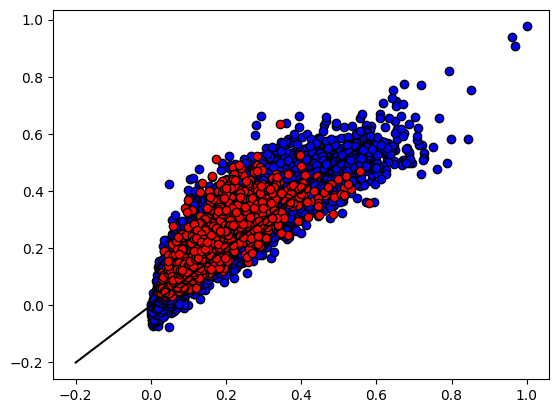

In [18]:
plt.scatter(train_results_pd["GT Drag"],train_results_pd["Pred Drag"],c="blue",edgecolor='black')
plt.scatter(test_results_pd["GT Drag"],test_results_pd["Pred Drag"],c="red",edgecolor='black')
plt.plot( np.linspace(-0.2,test_results_pd["GT Drag"].values.max(),10) , np.linspace(-0.2,test_results_pd["GT Drag"].values.max(),10),c='black')
print("R_2 = ",str(r2_score(test_results_pd["GT Drag"].values,test_results_pd["Pred Drag"].values)) )

R_2 =  0.31909149499811984


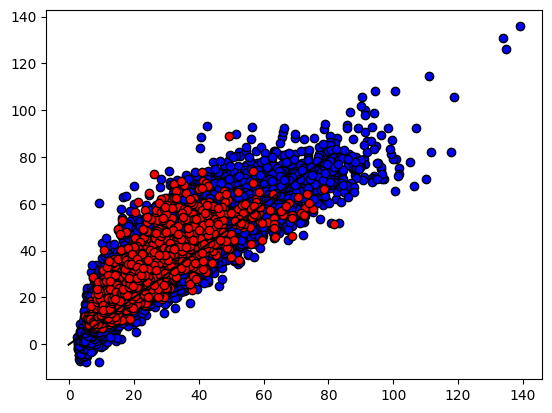

In [19]:
plt.scatter(train_results_pd["GT Drag Unscaled"],train_results_pd["Pred Drag Unscaled"],c="blue",edgecolor='black')
plt.scatter(test_results_pd["GT Drag Unscaled"],test_results_pd["Pred Drag Unscaled"],c="red",edgecolor='black')
plt.plot( np.linspace(-0.2,test_results_pd["GT Drag Unscaled"].values.max(),10) , np.linspace(-0.2,test_results_pd["GT Drag Unscaled"].values.max(),10),c='black')
print("R_2 = ",str(r2_score(test_results_pd["GT Drag Unscaled"].values,test_results_pd["Pred Drag Unscaled"].values)) )

In [ ]:
### Experiment-wise analysis ###

### Getting mean drag per experiment and adding as column ###
mean_drags_pd = pd.DataFrame(np.concatenate((all_tags,all_data_pd_scaled[:,-1][:,None]),axis=1),columns=["AR","Phi","Re","GT Drag"])
mean_drags_pd = mean_drags_pd.groupby(["AR","Phi","Re"]).mean()

### add mean drags to train_results_pd ###
# mean_drag_list = [mean_drags_pd.loc[(train_results_pd["AR"].values[i], train_results_pd["Phi"].values[i],train_results_pd["Re"].values[i]), 'GT Drag'] for i in range(len(train_results_pd))] 
# train_results_pd["Mean GT Drag"] = mean_drag_list

### add mean drags to test_results_pd ###
mean_drag_list = [mean_drags_pd.loc[(test_results_pd["AR"].values[i], test_results_pd["Phi"].values[i],test_results_pd["Re"].values[i]), 'GT Drag'] for i in range(len(test_results_pd))] 
test_results_pd["Mean GT Drag"] = mean_drag_list

### Defining Relative error ###

### Train ###
# train_results_pd["Rel Err"] = np.abs(train_results_pd["GT Drag"].values - train_results_pd["Pred Drag"].values)/train_results_pd["GT Drag"].values 
# train_results_pd["Rel Err From Mean Drag"] = np.abs(train_results_pd["GT Drag"].values - train_results_pd["Mean GT Drag"].values)/train_results_pd["GT Drag"].values

### Test ###
test_results_pd["Rel Err"] = np.abs(test_results_pd["GT Drag"].values - test_results_pd["Pred Drag"].values)/test_results_pd["GT Drag"].values  
test_results_pd["Rel Err From Mean Drag"] = np.abs(test_results_pd["GT Drag"].values - test_results_pd["Mean GT Drag"].values)/test_results_pd["GT Drag"].values

sns.distplot(test_results_pd["Rel Err"].values,color="blue")
sns.distplot(test_results_pd["Rel Err From Mean Drag"].values,color="red")

Garbage

In [ ]:
plt.plot(test_results_pd["Rel Err"])
plt.plot(test_results_pd["Rel Err From Mean Drag"],alpha=0.25)
plt.legend(["Rel Err","Rel Err From Mean Drag"])

In [ ]:
count, bins_count = np.histogram(test_results_pd["Rel Err"].values, bins=10) 
pdf = count / sum(count)
cdf = np.cumsum(pdf) 

count, bins_count = np.histogram(test_results_pd["Rel Err From Mean Drag"].values, bins=10) 
pdf = count / sum(count)
cdf_mean = np.cumsum(pdf) 
  
plt.plot(bins_count[1:], cdf, label="CDF Rel err") 
plt.plot(bins_count[1:], cdf_mean, label="CDF Rel err") 
plt.legend(["CDF","CFD Mean"]) 

In [ ]:
Re=10
Phi=30

test_subgroup = test_results_pd[(test_results_pd["Re"]==Re)&(test_results_pd["Phi"]==Phi)]
plt.scatter(test_subgroup["GT"],test_subgroup["Pred"],c="red",edgecolor='black')
plt.plot(np.linspace(test_subgroup["GT"].min(),test_subgroup["GT"].max(),10),
         np.linspace(test_subgroup["GT"].min(),test_subgroup["GT"].max(),10),c='black')
print(r2_score(test_subgroup["GT"].values,test_subgroup["Pred"].values))

In [ ]:
gt = test_subgroup["GT"].values
mean = np.ones(len(test_subgroup))*test_subgroup["GT"].values.mean()
pred = test_subgroup["Pred"].values

rel_err_mean = (np.abs(gt-mean)/(gt))*100
rel_err_pred = (np.abs(gt-pred)/(gt))*100
rel_err_mean.mean()

In [ ]:
### Define MLP model ###
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(66, 256),
            # nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256,64),
            # nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            # nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(16, 1) 
        )

    def forward(self, x):
        return self.layers(x)
        
model =  MLP()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))